<a href="https://colab.research.google.com/github/Vandanakosuri/Pneumonia-Xray-detectionn/blob/main/VNN_%26_Dense3Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

In [ ]:
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Activation, Input, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D,BatchNormalization, GlobalAveragePooling2D
from keras import regularizers
from keras.optimizers import Adam
import tensorflow as tf


import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/pediatric-pneumonia-chest-xray/data")

Skipping, found downloaded files in "./pediatric-pneumonia-chest-xray" (use force=True to force download)


In [ ]:
train_path = "../content/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train"
test_path = "../content/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test"

In [ ]:
normal_images = [img for img in os.listdir(f'{train_path}/NORMAL')]
pneumonia_images = [img for img in os.listdir(f'{train_path}/PNEUMONIA')]

In [ ]:
normal_select = np.random.choice(normal_images, 5, replace=False)
pneumonia_select = np.random.choice(pneumonia_images, 5, replace=False)

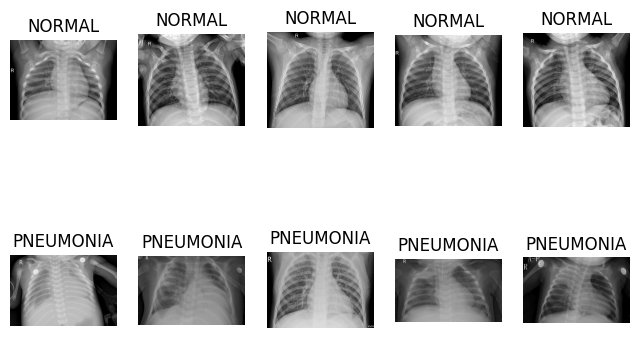

In [ ]:
#Plot the selected images
from tensorflow.keras.preprocessing import image
fig = plt.figure(figsize=(8,5))
for i in range(10):
    if i<5:
        fpath = f'{train_path}/NORMAL/{normal_select[i]}'
        label = 'NORMAL'
    else:
        fpath = f'{train_path}/PNEUMONIA/{pneumonia_select[i-5]}'
        label = 'PNEUMONIA'
    ax = fig.add_subplot(2,5,i+1)

    im = image.load_img(fpath)
    plt.imshow(im)
    plt.title(label)
    plt.axis('off')
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)

In [ ]:
batch_size = 8
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(180,180),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(180,180),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(180,180),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
vgg_model = Sequential()

vgg_pretrained_model=VGG16(include_top=False,input_shape=(180,180,3),pooling='avg',classes=2,weights='imagenet')

for layer in vgg_pretrained_model.layers:
        layer.trainable=False

vgg_model.add(vgg_pretrained_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dense(2, activation='sigmoid'))

In [ ]:
vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 14978370 (57.14 MB)
Trainable params: 263682 (1.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:

vgg_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=["accuracy","AUC","Precision","Recall"])

vgg_model_history = vgg_model.fit(train_generator, validation_data=train_generator, epochs=3)

Epoch 1/3
524/524 [==============================] - 3121s 6s/step - loss: 0.2527 - accuracy: 0.8956 - auc: 0.9620 - precision: 0.8952 - recall: 0.8954 - val_loss: 0.1588 - val_accuracy: 0.9362 - val_auc: 0.9849 - val_precision: 0.9352 - val_recall: 0.9369
Epoch 2/3
157/524 [=======>......................] - ETA: 17:47 - loss: 0.1911 - accuracy: 0.9252 - auc: 0.9774 - precision: 0.9252 - recall: 0.9260

NameError: ignored

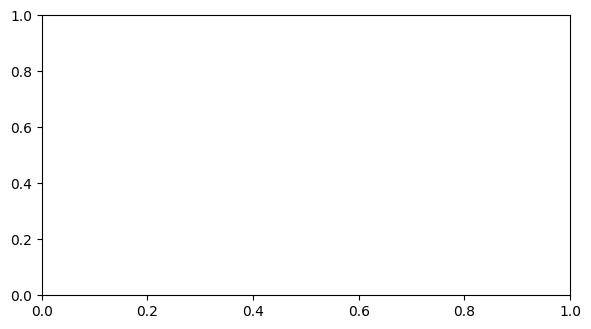

In [ ]:
plt.figure(1, figsize = (15,8))

plt.subplot(221)
plt.plot(vgg_model_history.history['accuracy'])
plt.plot(vgg_model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(vgg_model_history.history['loss'])
plt.plot(vgg_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

In [ ]:
test_generator.reset()

pred = vgg_model.predict(test_generator, steps = len(test_generator), verbose = 2)

predicted_class_indices = np.argmax(pred, axis = 1)

624/624 - 245s - 245s/epoch - 393ms/step


In [ ]:
def Targetization(folder_path, target_path):
    label = []
    for path, tag in target_path:
        for filename in os.listdir(folder_path + path):
            img = cv2.imread(os.path.join(folder_path, path, filename)) # second param: 0 is b&w picture
            if img is not None:
                label.append(tag)
    return np.array(label)



In [ ]:
base_dir= "../content/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/"
y_test = Targetization(base_dir, target_path=[("test/NORMAL/", 0,), ("test/PNEUMONIA/", 1,)])

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.8653846153846154
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       234
           1       0.85      0.95      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.84      0.85       624
weighted avg       0.87      0.87      0.86       624



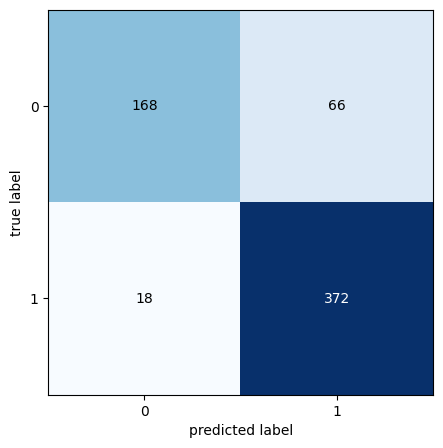

In [ ]:
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(classification_report(y_test, predicted_class_indices))
plt.show()

**DenseNet121 Implementation**

In [ ]:
denset_net_pretrained_model = DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=(180, 180, 3)))
# construct the head of the model that will be placed on top of the
# the base model
dense_net_model = Sequential()
dense_net_model.add(denset_net_pretrained_model)
dense_net_model.add(GlobalAveragePooling2D())
dense_net_model.add(Flatten())
dense_net_model.add(Dropout(0.5))
dense_net_model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
dense_net_model.add(Dropout(0.5))
dense_net_model.add(Dense(2, activation='sigmoid'))
for layer in denset_net_pretrained_model.layers[:]:
    layer.trainable = False

conv_base is now NOT trainable


In [ ]:
dense_net_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 5, 5, 1024)        7037504   
                                                                 
 global_average_pooling2d_5  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_5 (Flatten)         (None, 1024)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               131200    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                      

In [ ]:
dense_net_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=["accuracy","AUC","Precision","Recall"])

history_dense_net_model = dense_net_model.fit(train_generator, validation_data=train_generator, epochs=3)

Epoch 1/3
524/524 [==============================] - 927s 2s/step - loss: 0.4987 - accuracy: 0.8428 - auc: 0.9104 - precision: 0.8340 - recall: 0.8388 - val_loss: 0.2911 - val_accuracy: 0.9202 - val_auc: 0.9760 - val_precision: 0.9168 - val_recall: 0.9209
Epoch 2/3
524/524 [==============================] - 889s 2s/step - loss: 0.3603 - accuracy: 0.8832 - auc: 0.9505 - precision: 0.8796 - recall: 0.8760 - val_loss: 0.2720 - val_accuracy: 0.9381 - val_auc: 0.9843 - val_precision: 0.9409 - val_recall: 0.9348
Epoch 3/3
524/524 [==============================] - 949s 2s/step - loss: 0.3221 - accuracy: 0.8923 - auc: 0.9600 - precision: 0.8931 - recall: 0.8920 - val_loss: 0.2326 - val_accuracy: 0.9427 - val_auc: 0.9865 - val_precision: 0.9435 - val_recall: 0.9408


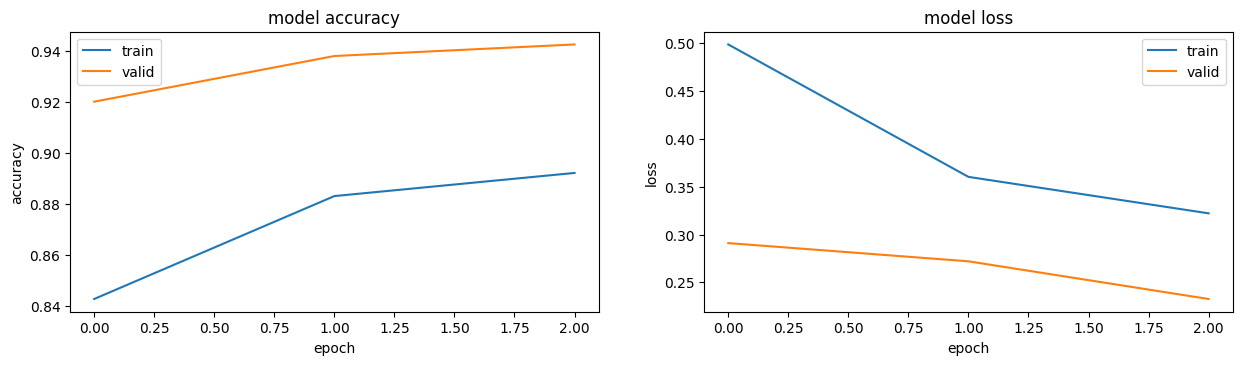

In [ ]:
plt.figure(1, figsize = (15,8))

plt.subplot(221)
plt.plot(history_dense_net_model.history['accuracy'])
plt.plot(history_dense_net_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(history_dense_net_model.history['loss'])
plt.plot(history_dense_net_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

In [ ]:
test_generator.reset()

pred = dense_net_model.predict(test_generator, steps = len(test_generator), verbose = 2)

predicted_class_indices = np.argmax(pred, axis = 1)

624/624 - 74s - 74s/epoch - 118ms/step


In [ ]:
base_dir= "../content/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/"
y_test = Targetization(base_dir, target_path=[("test/NORMAL/", 0,), ("test/PNEUMONIA/", 1,)])

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='predicted label', ylabel='true label'>)
0.8205128205128205
              precision    recall  f1-score   support

           0       0.89      0.60      0.71       234
           1       0.80      0.95      0.87       390

    accuracy                           0.82       624
   macro avg       0.84      0.78      0.79       624
weighted avg       0.83      0.82      0.81       624



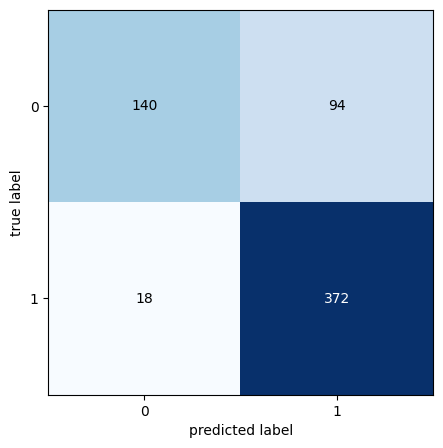

In [ ]:
print(plot_confusion_matrix(confusion_matrix(y_test, predicted_class_indices), figsize=(5,5)))
print(accuracy_score(y_test, predicted_class_indices))
print(classification_report(y_test, predicted_class_indices))
plt.show()